In [9]:
import sys
sys.path.append('C:/Users/dinle/Code/Learning/Py_Code/AI_Learning/NodeLayer')
sys.path.append('C:/Users/dinle/Code/Learning/Py_Code/AI_Learning/mnist')
from NodeLayer.simple_convnet import SimpleConvNet as cv1
from mnist.ch07.simple_convnet import SimpleConvNet as cv2

import matplotlib.pyplot as plt
from mnist.dataset.mnist import load_mnist
from mnist.common.util import smooth_curve
from mnist.common.optimizer import *
import numpy as np


In [10]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
test_size = x_test.shape[0]
batch_size = 128
max_iterations = 500
mi = np.arange(max_iterations)
optimizer = AdaGrad()

In [11]:
def test(test_list):
    networks = {}
    train_acc = {}
    train_loss = {}
    test_acc = {}
    test_loss = {}
    optimizer = {}


    for key in test_list.keys():
        # 기록 리스트 생성
        train_acc[key] = []
        train_loss[key] = []
        test_acc[key] = []
        test_loss[key] = []

        # nSigmoid 경우 파라미터
        # key == 'nSigmoid_8' -> act = nSigmoid, threshold = 8
        model = test_list[key]['model']
        lr = test_list[key]['lr']


        # 네트워크와 optimizer 생성
        if model == 'cv1':
            networks[key] = cv1()
        else:
            networks[key] = cv2()
        optimizer[key] = AdaGrad(lr)

    # 학습
    for i in range(max_iterations):

        # mini-batch train
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]

        # mini-batch test
        batch_mask_t = np.random.choice(test_size, batch_size)
        x_batch_t = x_test[batch_mask_t]
        t_batch_t = t_test[batch_mask_t]

        if i % 10 == 0:
            print( "===========" + "iteration:" + str(i) + "===========")

        # 학습
        for key in test_list.keys():

            x_batch = x_batch.reshape(-1, 1, 28, 28)
            x_batch_t = x_batch_t.reshape(-1, 1, 28, 28)
            # 학습
            grads = networks[key].gradient(x_batch, t_batch)
            optimizer[key].update(networks[key].params, grads)

            # 기록
            train_acc[key].append(networks[key].accuracy(x_batch, t_batch))
            train_loss[key].append(networks[key].loss(x_batch, t_batch))
            test_acc[key].append(networks[key].accuracy(x_batch_t, t_batch_t))
            test_loss[key].append(networks[key].loss(x_batch_t, t_batch_t))

            # 100회마다 경과 출력
            if i % 10 == 0:
                # print(key + " loss:" + str(acc))
                t_loss = networks[key].loss(x_batch_t, t_batch_t)
                print(key + " loss:" + str(t_loss))

    return train_acc, train_loss, test_acc, test_loss


def plot(label, datas, t_list, *y_lim):
    for key in t_list:
        plt.plot(mi, smooth_curve(datas[key]), markevery=50, label=key)
    plt.xlabel("iterations")
    plt.ylabel(label)
    if y_lim:
        plt.ylim(y_lim)
    plt.legend()
    plt.show()

In [12]:
test_list = {
             'cv1':
                 {'model':'cv1','lr':0.01},
             'cv2':
                {'model':'cv2','lr':0.01},
             }



train_acc, train_loss, test_acc, test_loss = test(test_list)

===========iteration:0===========
cv1 loss:2.2741339258963382
cv2 loss:2.290481675341189
===========iteration:10===========
cv1 loss:0.8721273240872092
cv2 loss:0.8180117572567469
===========iteration:20===========
cv1 loss:0.5258526667059373
cv2 loss:0.5190205812941167
===========iteration:30===========
cv1 loss:0.5004115123729201
cv2 loss:0.47065493650248813
===========iteration:40===========
cv1 loss:0.34118757307872205
cv2 loss:0.3555830858249884
===========iteration:50===========
cv1 loss:0.323647025374977
cv2 loss:0.38584755642417856
===========iteration:60===========
cv1 loss:0.2510692973767861
cv2 loss:0.28699594154975483
===========iteration:70===========
cv1 loss:0.37016977546994034
cv2 loss:0.43707924341475896
===========iteration:80===========
cv1 loss:0.21581494391420908
cv2 loss:0.24592001806216068
===========iteration:90===========
cv1 loss:0.1594295092453522
cv2 loss:0.1880619883718293
===========iteration:100===========
cv1 loss:0.20527213036704112
cv2 loss:0.264173419

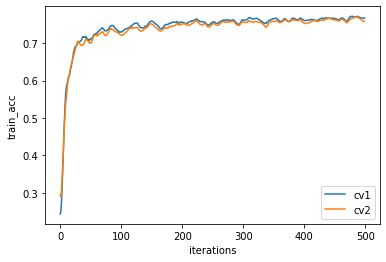

In [13]:
plot('train_acc', train_acc, test_list)

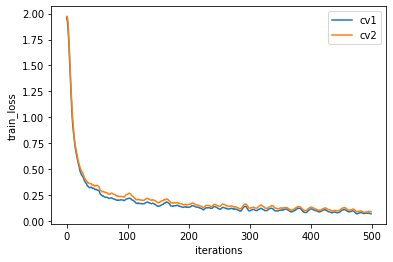

In [14]:
plot('train_loss', train_loss, test_list)